Rohan Bhatt - MSML604 HW7

In [8]:
#problem 1
import numpy as np
import matplotlib.pyplot as plt

#defining the problem data, setting all types to floats for numpy calc purposes
P = np.array([[5, 4, 6],
              [4, 9, 15],
              [6, 15, 35]], dtype=float)
q = np.array([5, 7, 6], dtype=float)
#initial point
x0 = np.array([2, 4, 6], dtype=float) 

#defining f(x) as stated in the problem:
def f(x):
    return .5*x @ P @ x + q @ x
#defining the gradient of f(x)
def grad(x):
    return P @ x + q

#part a (armijo backtracking)
def gradient(x0, alpha_init=2, gamma=0.5, beta=0.8, tol=1e-10, max_iterations=2_000, verbose = False): #putting alpha gamma beta in the parameters, along with the tolerance for convergence
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)]
    for k in range(max_iterations):
        g = grad(x) #current gradient
        #stopping test
        if np.linalg.norm(g) < tol:
            if verbose:
                print(f"Converged ‖∇f‖={np.linalg.norm(g):.2e} at k={k}")
            break
        #armijo line search
        alpha = alpha_init #starting with a_initi
        #condition is f( x - alpha*g) <= f(x) - beta*alpha*np.linalg.norm(g)**2
        while f(x - alpha * g) > f(x) - beta * alpha * (g @ g):
            alpha *= gamma # shrink α ← γ α
            #print(f"alpha: {alpha}")

        #gradient descent step
        x = x - alpha * g
        f_hist.append(f(x))
        if verbose:
            print(f"Iteration {k}: x = {x}, f(x) = {f_hist[-1]}, alpha = {alpha}")
    return x, f_hist #returning the last iterate and the objective values at each iterate (f(x0), f(x1), ...)
x_gd, vals_gd  = gradient(x0)
print(x_gd)
print(vals_gd)


Matplotlib is building the font cache; this may take a moment.


[-0.47552455 -1.45804181  0.53496499]
[np.float64(1250.0), np.float64(552.8991088867188), np.float64(246.40335679613054), np.float64(111.4582507259953), np.float64(51.868383038838886), np.float64(25.3898412071853), np.float64(13.4706500110642), np.float64(7.962815126964439), np.float64(5.287146159918638), np.float64(3.870836525363692), np.float64(2.3585350323278993), np.float64(0.858972922453785), np.float64(-1.1854568636975578), np.float64(-1.8496239591138455), np.float64(-2.786204554567641), np.float64(-3.0992187653522842), np.float64(-3.559203771261726), np.float64(-3.8511756087051845), np.float64(-3.965315851503094), np.float64(-4.132686327200712), np.float64(-4.1988704503834455), np.float64(-4.384813523556016), np.float64(-4.407289454475465), np.float64(-4.459876600199643), np.float64(-4.4841996619003295), np.float64(-4.522109689535976), np.float64(-4.538752556091925), np.float64(-4.5893457777967415), np.float64(-4.595845512021234), np.float64(-4.612294329859623), np.float64(-4.61

In [9]:
#1b - using conjugate gradient
def conjugate_gradient(x0, tol=1e-10, max_iterations=10, verbose = False):
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)]
    r = -grad(x) # initial residual r0 = -∇f(x0)
    p = r.copy() # first search direction
    for k in range(max_iterations):
        Ap = P @ p # matrix-vector product
        alpha = r @ r / (p @ Ap) #exact line search step size
        x = x + alpha * p #update the iterate
        r_new = r - alpha * Ap #new residual (-gradient)

        f_hist.append(f(x))
        if verbose:
            print(f"k={k} ---------------\n α={alpha} ---------------\n ‖r‖={np.linalg.norm(r_new)}"f" ---------------\n f={f_hist[-1]}")
        #convergence test
        if np.linalg.norm(r_new) < tol:
            break
        beta = r_new @ r_new / (r @ r) #fletcher-reeves formula
        p = r_new + beta * p
        r = r_new
    return x, f_hist 
    
x_cg, vals_cg = conjugate_gradient(x0)
print(x_cg)
print(vals_cg)
print("converged in", len(vals_cg) - 1, "iterations")

[-0.47552448 -1.45804196  0.53496503]
[np.float64(1250.0), np.float64(6.281116907880326), np.float64(-3.7460673291990103), np.float64(-4.687062937062938)]
converged in 3 iterations


In [10]:
#part c - hessian is constant and PSD so one exact newton step lands exactly on the minimiser.
def newton(x0, tol=1e-10, max_iterations=10, verbose = False):
    x = x0.copy().astype(float) #copying the initial point
    f_hist = [f(x)] #initialising the function history with the first value

    H_inv = np.linalg.inv(P) # constant inverse Hessian

    for k in range(max_iterations):

        g = grad(x) # gradient at current iterate
        if np.linalg.norm(g) < tol: # stopping test
            break

        # newton step
        x = x - H_inv @ g
        f_hist.append(f(x))

        if verbose:
            print(f"k={k} // ‖∇f‖={np.linalg.norm(g)} // f={f_hist[-1]}")

        # with a quadratic / constant Hessian we’re done in ≤1 step
        if np.linalg.norm(grad(x)) < tol:
            break

    return x, f_hist
x_star_new, vals_new = newton(x0, verbose=True)
print(x_star_new)
print(vals_new[-1])
print("  iterations =", len(vals_new)-1)

k=0 // ‖∇f‖=327.5881560740559 // f=-4.6870629370629375
[-0.47552448 -1.45804196  0.53496503]
-4.6870629370629375
  iterations = 1


In [11]:
#1d - DFP method
# DFP inverse-hessian updates with exact line search
def dfp(x0, tol=1e-10, max_iterations=20, verbose = False):
    x = x0.copy().astype(float) #copying the initial point
    n = len(x) # 
    H = np.eye(n) # initial inverse‑Hessian guess (I)
    f_hist = [f(x)] 
    g = grad(x)

    for k in range(max_iterations):
        #getting search direction p_k  = -H_k * ∇f(x_k)
        p = -H @ g
        #exact line search for a quadratic  α_k = -(gTp) / (pT P p)
        alpha = -(g @ p) / (p @ P @ p)
        #updating the iterate
        x_new  = x + alpha * p
        g_new = grad(x_new)
        s = x_new - x #step size
        y = g_new - g #change in gradient

        f_hist.append(f(x_new))
        if verbose:
             print(f"k={k} // ‖∇f‖={np.linalg.norm(g)} // f={f_hist[-1]} // a={alpha}")
        #stopping test
        if np.linalg.norm(g_new) < tol:
            break
        
        #DFP UPDATE: H_{k+1} = H_k + (ss^T)/(y^T s) - (H_k y y^T H_k)/(y^T H_k y)
        ys = y @ s
        if ys <= 0:
            raise RuntimeError("curvature condition violated")
        Hy = H @ y
        H = H + np.outer(s, s) / ys - np.outer(Hy, Hy) / (y @ Hy)
        #prepping next loop
        x = x_new
        g = g_new
    return x, f_hist
x_star_dfp, vals_dfp = dfp(x0, verbose=True)
print(x_star_dfp)
print(vals_dfp[-1])
print("iterations =", len(vals_dfp)-1)


k=0 // ‖∇f‖=327.5881560740559 // f=6.281116907880326 // a=0.023179061130740065
k=1 // ‖∇f‖=8.981559986011495 // f=-3.7460673291990148 // a=0.24878934641232228
k=2 // ‖∇f‖=1.7611342100908438 // f=-4.687062937062936 // a=0.6301294945548398
[-1.08413241 -0.59733343  0.26169705]
-4.687062937062936
iterations = 3


In [12]:
#1e BFGS like DFP where it converges in <=n iterations but usually more stable
def bfgs(x0, tol=1e-10, max_iterations=20, verbose = False):
    x = x0.copy().astype(float)
    n = len(x)
    H = np.eye(n) # initial inverse‑Hessian guess
    f_hist = [f(x)]
    g = grad(x)

    for k in range(max_iterations):
        #search direction p_k  = -H_k * ∇f(x_k)
        p = -H @ g
        #exact line search for quadratic α_k = -(gTp) / (pT P p)
        alpha = -(g @ p) / (p @ P @ p)

        x_new = x + alpha * p
        g_new = grad(x_new)
        s = x_new - x
        y = g_new - g

        f_hist.append(f(x_new))
        if verbose:
            print(f"k={k} // ‖∇f‖={np.linalg.norm(g)} // f={f_hist[-1]} // a={alpha}")

        #BFGS update 
        ys = y @ s
        if ys <= 0:
            raise RuntimeError("curvature condition violated")
        rho = 1.0 / ys
        I = np.eye(n)
        H = (I - rho * np.outer(s, y)) @ H @ (I - rho * np.outer(y, s)) + rho * np.outer(s, s)
        #advance vars
        x, g = x_new, g_new
        #stopping test
        if np.linalg.norm(g_new) < tol:
            break
    return x, f_hist
x_star_bfgs, vals_bfgs = bfgs(x0, verbose=True)
print(x_star_bfgs)
print(vals_bfgs[-1])
print("iterations =", len(vals_bfgs)-1)

k=0 // ‖∇f‖=327.5881560740559 // f=6.281116907880326 // a=0.023179061130740065
k=1 // ‖∇f‖=8.981559986011495 // f=-3.7460673291990156 // a=0.2486024708091936
k=2 // ‖∇f‖=1.7611342100908454 // f=-4.687062937062935 // a=0.6067819947261619
[-0.47552448 -1.45804196  0.53496503]
-4.687062937062935
iterations = 3


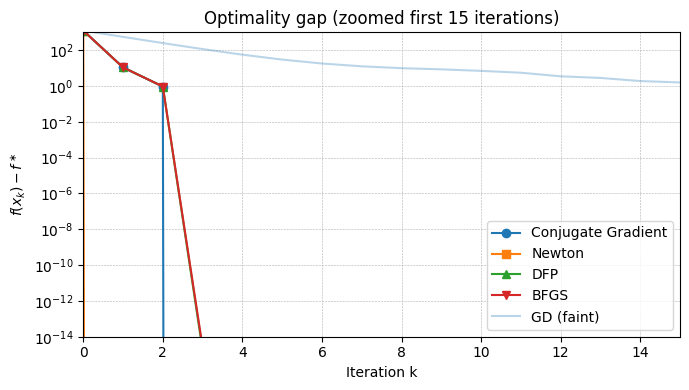

In [13]:
#running each solver ocne and collecting objective histories, already ran vals_gd earlier for 1A
x_cg, vals_cg = conjugate_gradient(x0)
x_new, vals_new = newton(x0)
x_dfp, vals_dfp = dfp(x0)
x_bfgs, vals_bfgs = bfgs(x0)
#getting the optimality gap
f_star = vals_new[-1] #f* = -4.68....
gap_gd   = np.array(vals_gd) - f_star
gap_cg   = np.array(vals_cg) - f_star
gap_new  = np.array(vals_new) - f_star 
gap_dfp  = np.array(vals_dfp) - f_star  
gap_bfgs = np.array(vals_bfgs)- f_star
#plotting the results, zooming in on the first 15 iterations
plt.figure(figsize=(7,4))
#putting distinct markers for each method
plt.semilogy(gap_cg,   marker='o', label="Conjugate Gradient")
plt.semilogy(gap_new,  marker='s', label="Newton")
plt.semilogy(gap_dfp,  marker='^', label="DFP")
plt.semilogy(gap_bfgs, marker='v', label="BFGS")
#regular GD shown faintly in the background
plt.semilogy(gap_gd,   color='C0', alpha=0.3, label="GD (faint)")
#our interesting region
plt.xlim(0, 15)
plt.ylim(1e-14, 1e3)
#setting axis details like labels, title, etc
plt.xlabel("Iteration k")
plt.ylabel(r"$f(x_k)-f^\ast$")
plt.title("Optimality gap (zoomed first 15 iterations)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.4)
plt.tight_layout()


dual ascent iterations : 66
x* dual ascent:[ 0.49399245 -1.18367584  0.14466922]
x* analytic KKT:[ 0.49399245 -1.18367584  0.14466922]
ν* dual ascent:[-1.23671652  1.03353221]
ν* analytic KKT: [-1.23671652  1.03353221] [-1.23671652  1.03353221]
||Ax* - b|| 7.793164330405879e-11


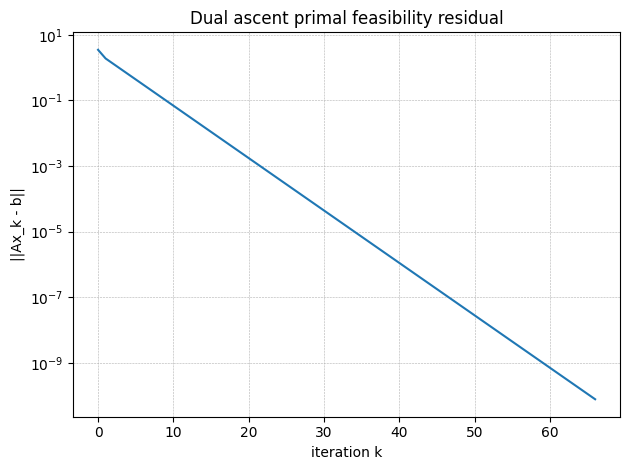

In [17]:
#Problem 2:

#initial problem data
P = np.array([[5, 4, 6], #hessian symmetric PD
              [4, 9, 15],
              [6, 15, 35]])

q = np.array([5, 7, 6]) #linear term

A = np.array([[4.0, 0.9, 2.0], #2 x 3 constraint matrix
              [1.3, 0.6, 6.0]])

b = np.array([1.2, 0.8]) 

#quantities that do not change
P_inv = np.linalg.inv(P) #inverse hessian 3x3
APA = A @ P_inv @ A.T # 2x2 SPD matrix (A P^-1 A^T)
APq  = A @ P_inv @ q #2 vector (A P^-1 q)

# dual ascent algo parameters
nu = np.zeros(2) #v0 = [0,0]^T
max_iterations = 200 #hard iteration cap
tol = 1e-10 #tolerance
res_hist = [] #store ||Ax_k - b|| at each step

# choose fixed step size α = 1 / lambda_max(APA)  (optimal for GD on quadratic dual)
alpha = 1.0 / np.linalg.eigvalsh(APA).max()

#main dual ascent loop
for k in range(max_iterations):
    # primal minimiser x(v_k), solving Px + q + A^T ν = 0 -> x_k = -P^-1 (q + A^T v_k)
    x = -P_inv @ (q + A.T @ nu)

    # primal residual  r_k = Ax_k − b
    r = A @ x - b
    res_hist.append(np.linalg.norm(r))

    #stopping test if feasibility is satisfied
    if res_hist[-1] < tol:
        break

    # dual var update -> v_k+1 = v_k + ar_k
    nu = nu + alpha * r

# closed form KKT solution for verification,  solve [PA^T; A 0][x; ν] = [-q; b]
KKT = np.block([[P, A.T],[A, np.zeros((2,2))]]) #5x5 system
rhs = -np.concatenate([q, -b]) # because KKT uses -q
solution = np.linalg.solve(KKT, rhs) #
real_x_star = solution[:3]
real_nu_star = solution[3:]

# showing results
print(f"dual ascent iterations : {k}")
print(f"x* dual ascent:{x}")
print(f"x* analytic KKT:{real_x_star}")
print(f"ν* dual ascent:{nu}")
print(f"ν* analytic KKT: {real_nu_star}", real_nu_star)
print(f"||Ax* - b||", res_hist[-1])

# plot residual decay
plt.semilogy(res_hist)
plt.xlabel("iteration k")
plt.ylabel(r"||Ax_k - b||")
plt.title("Dual ascent primal feasibility residual")
plt.grid(True, which="both", ls='--', lw=0.4)
plt.tight_layout()
plt.show()

